In [8]:
#100043
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


#paper api
api = tradeapi.REST('PKAADT32B4ZQWT88QB6K', 'Pa12WaqgsKtSnQUxfrNqSmOhDVG5guS1LVqtMlLK', base_url='https://paper-api.alpaca.markets')

#api = tradeapi.REST('AKYZUR3PABG4AH39LMUC','GyCiPu5SQXovKXLl4QLe2JbXcXNfCzomjNjiVAmT','https://api.alpaca.markets')

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/3688993718.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Close'][i] > data['SMA_50'][i] and data['MACD'][i] > data['Signal_Line'][i] and data['RSI_14'][i] < 70:
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/3688993718.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Close'][i] < data['EMA_20'][i] and data['MACD'][i] < data['Signal_Line'][i] and data['RSI_14'][i] > 30:


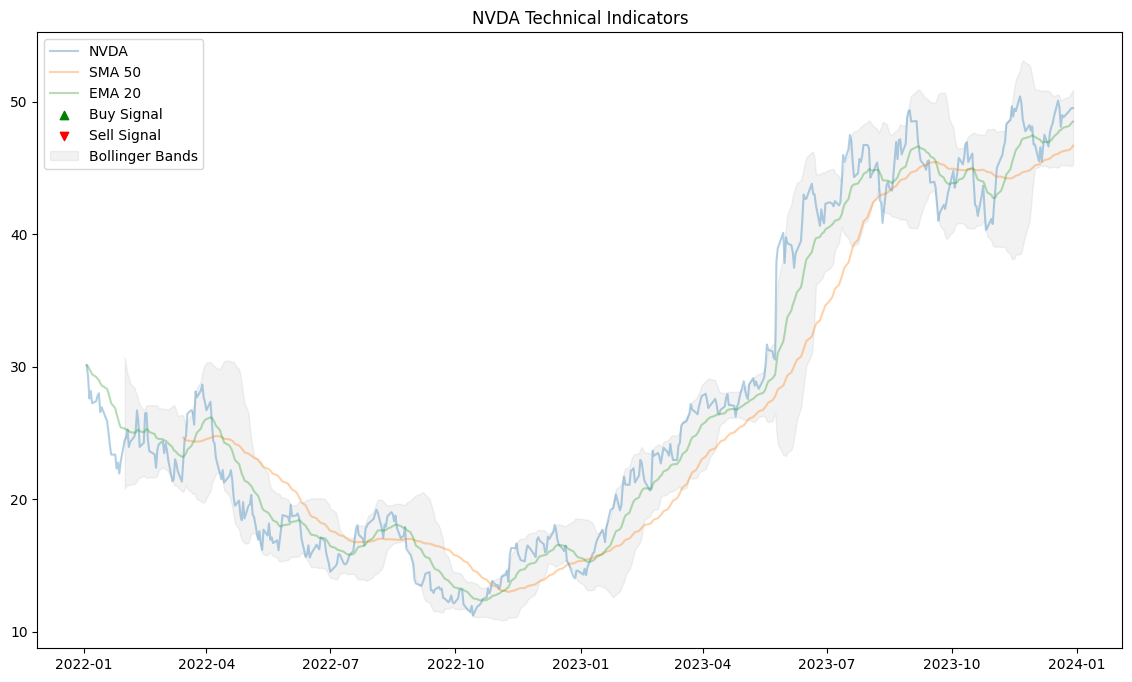

In [15]:
def SMA(data, window):
    return data['Close'].rolling(window=window).mean()

def EMA(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

def RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = EMA(data, short_window)
    long_ema = EMA(data, long_window)
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def Bollinger_Bands(data, window=20, num_std=2):
    sma = SMA(data, window)
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

def ATR(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

# Fetch historical data
ticker = 'NVDA'
data = yf.download(ticker, start="2022-01-01", end="2024-01-01")

# Apply indicators
data['SMA_50'] = SMA(data, 50)
data['EMA_20'] = EMA(data, 20)
data['RSI_14'] = RSI(data)
data['MACD'], data['Signal_Line'] = MACD(data)
data['Upper_Band'], data['Lower_Band'] = Bollinger_Bands(data)
data['ATR'] = ATR(data)

# Fibonacci Retracement (Assume we calculate for the last major trend)
data['Min'] = data['Close'].min()
data['Max'] = data['Close'].max()
fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
for level in fib_levels:
    data[f'Fib_{level}'] = data['Max'] - (data['Max'] - data['Min']) * level

# Example Strategy
buy_signals = []
sell_signals = []

for i in range(len(data)):
    if data['Close'][i] > data['SMA_50'][i] and data['MACD'][i] > data['Signal_Line'][i] and data['RSI_14'][i] < 70:
        buy_signals.append(data['Close'][i])
        sell_signals.append(np.nan)
    elif data['Close'][i] < data['EMA_20'][i] and data['MACD'][i] < data['Signal_Line'][i] and data['RSI_14'][i] > 30:
        sell_signals.append(data['Close'][i])
        buy_signals.append(np.nan)
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)

data['Buy_Signal'] = buy_signals
data['Sell_Signal'] = sell_signals

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label=ticker, alpha=0.35)
plt.plot(data['SMA_50'], label='SMA 50', alpha=0.35)
plt.plot(data['EMA_20'], label='EMA 20', alpha=0.35)
plt.scatter(data.index, data['Buy_Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(data.index, data['Sell_Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], color='gray', alpha=0.1, label='Bollinger Bands')
plt.title(f'{ticker} Technical Indicators')
plt.legend(loc='upper left')
plt.show()

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed


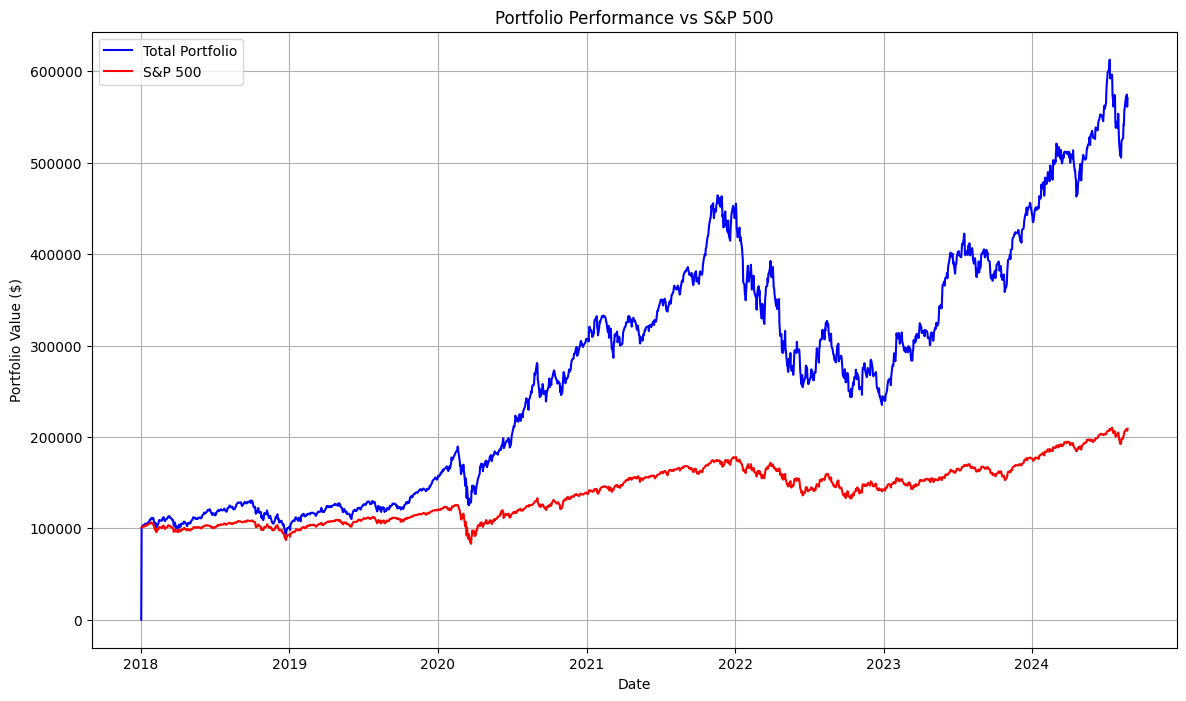

            Trend Following  Volatility Breakout    Retracement  \
Date                                                              
2024-08-19     95533.471655        240007.680302  148631.049432   
2024-08-20     95965.347016        241165.893735  147527.786155   
2024-08-21     95645.633385        242516.192598  149136.019398   
2024-08-22     94342.522524        233874.417685  145895.992480   
2024-08-23     95109.315158        238882.502286  148000.639462   

            Comprehensive Market  Short-Term Trading  Total Portfolio  
Date                                                                   
2024-08-19          42254.923826        45594.582464    572021.707678  
2024-08-20          41641.323581        45360.709629    571661.060115  
2024-08-21          41643.465817        45680.114158    574621.425356  
2024-08-22          41986.372996        45184.914447    561284.220132  
2024-08-23          42612.071428        45989.292156    570593.820490  


In [17]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

strategies = {
    "Trend Following": ["AAPL", "MSFT", "GOOGL"],
    "Volatility Breakout": ["TSLA", "AMD", "NFLX"],
    "Retracement": ["AMZN", "NVDA", "META"],
    "Comprehensive Market": ["JPM", "GS", "BAC"],
    "Short-Term Trading": ["SPY", "QQQ", "IWM"]
}

start_date = "2018-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

def calculate_strategy_returns(stocks, initial_allocation):
    data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().mean(axis=1)
    cumulative_returns = (1 + returns).cumprod() * initial_allocation
    return cumulative_returns

portfolio_returns = {}

for strategy, stocks in strategies.items():
    portfolio_returns[strategy] = calculate_strategy_returns(stocks, 20000)

portfolio_df = pd.DataFrame(portfolio_returns)

portfolio_df['Total Portfolio'] = portfolio_df.sum(axis=1)

sp500_data = yf.download("^GSPC", start=start_date, end=end_date)['Adj Close']
sp500_returns = (1 + sp500_data.pct_change()).cumprod() * 100000

plt.figure(figsize=(14, 8))
plt.plot(portfolio_df.index, portfolio_df['Total Portfolio'], label="Total Portfolio", color="blue")
plt.plot(sp500_returns.index, sp500_returns, label="S&P 500", color="red")
plt.title('Portfolio Performance vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

print(portfolio_df.tail())

[*********************100%%**********************]  1 of 1 completed


/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_ma > long_ma] = 1.0


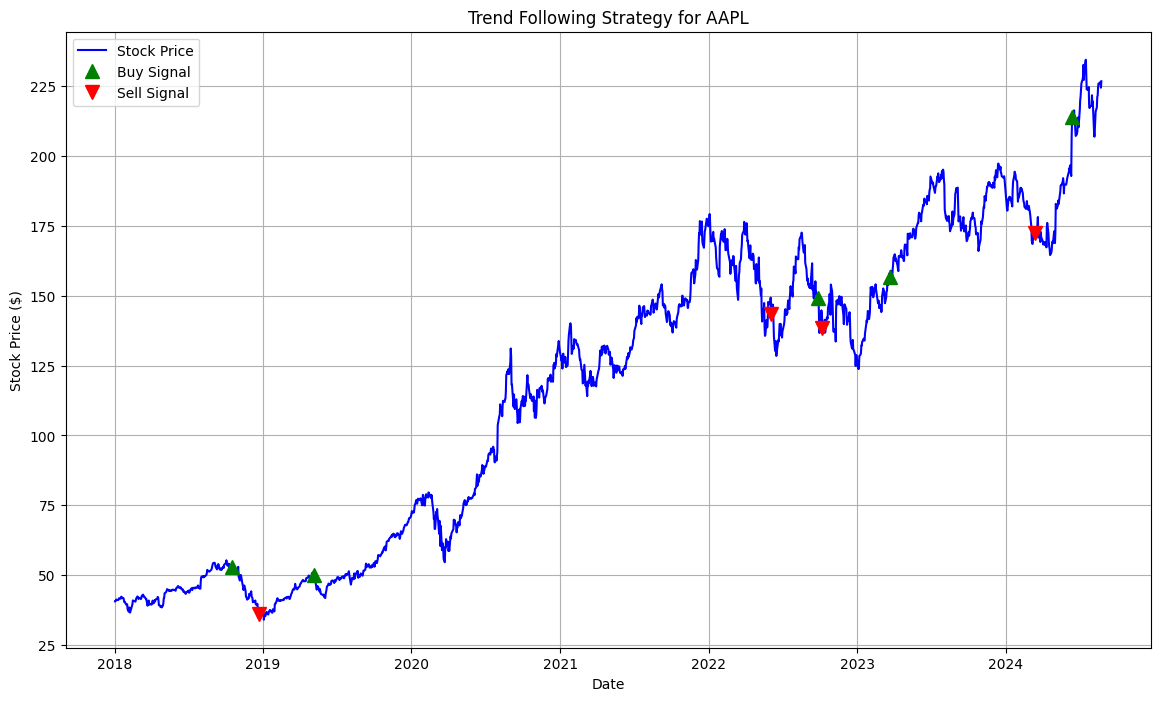

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_ma > long_ma] = 1.0

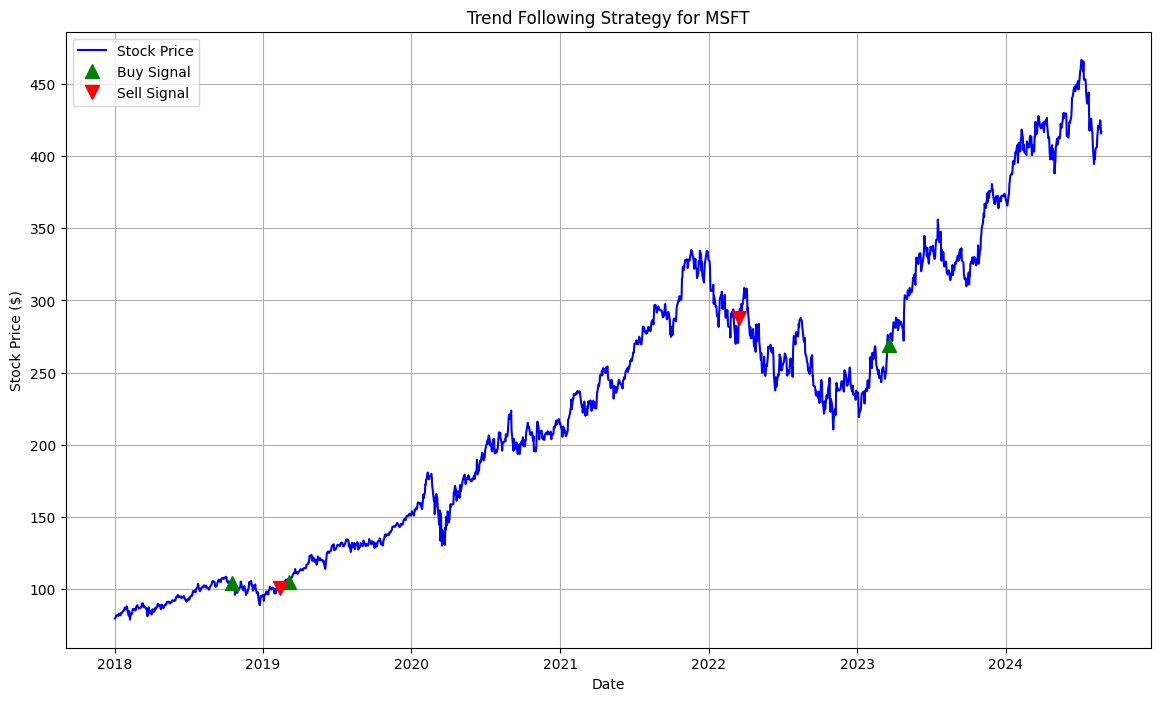

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_ma > long_ma] = 1.0

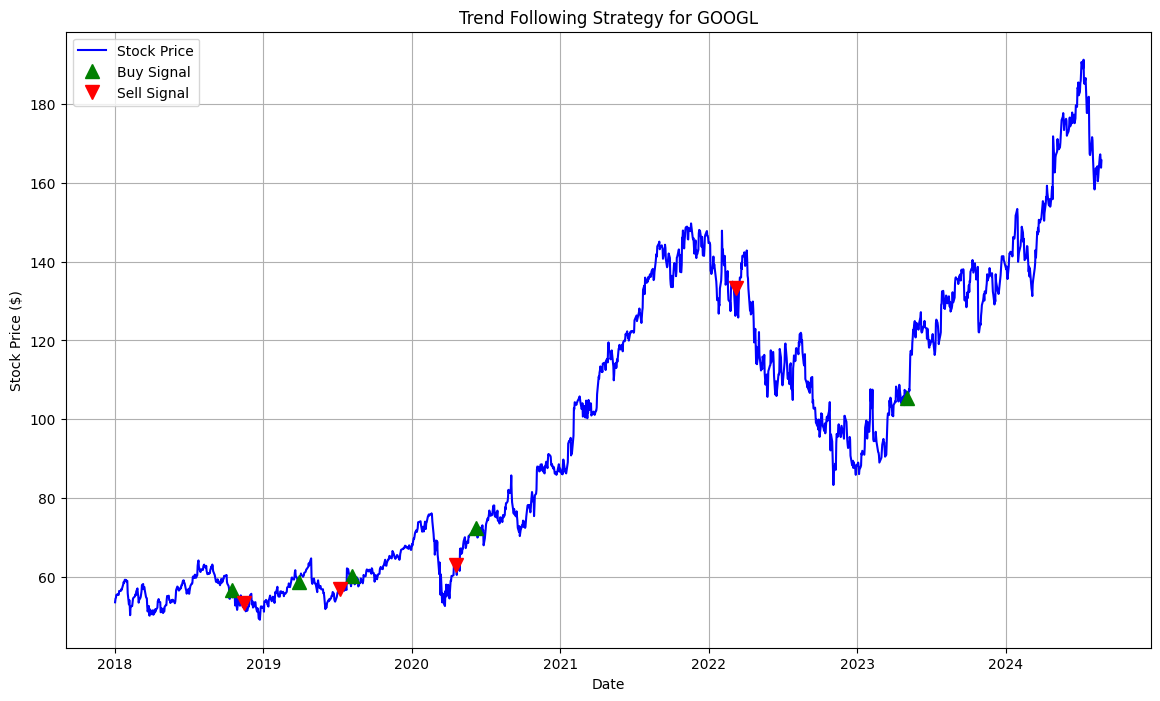

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data > upper_band] = 1.0


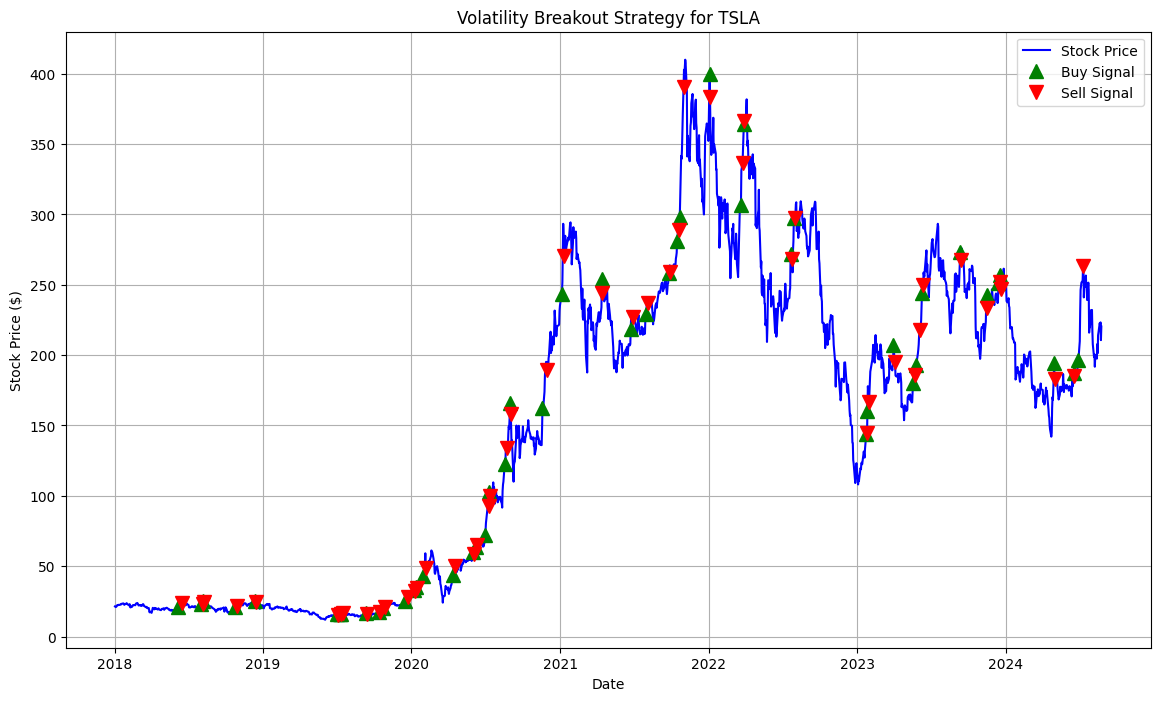

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data > upper_band] = 1.0


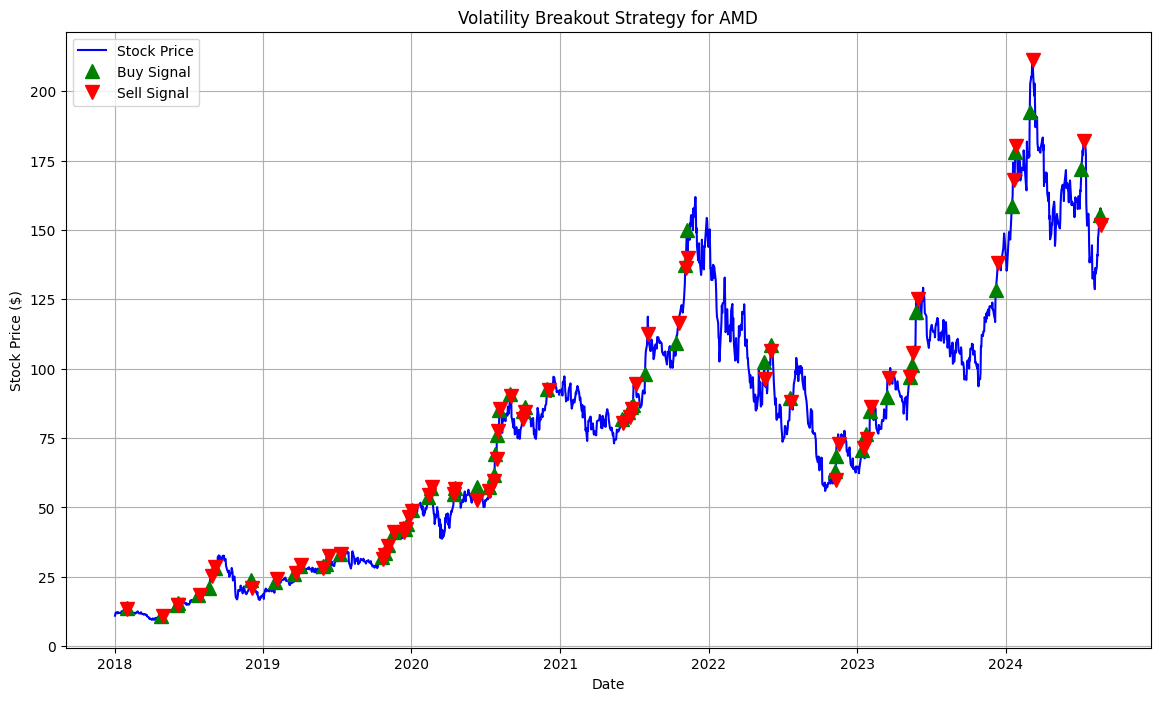

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data > upper_band] = 1.0


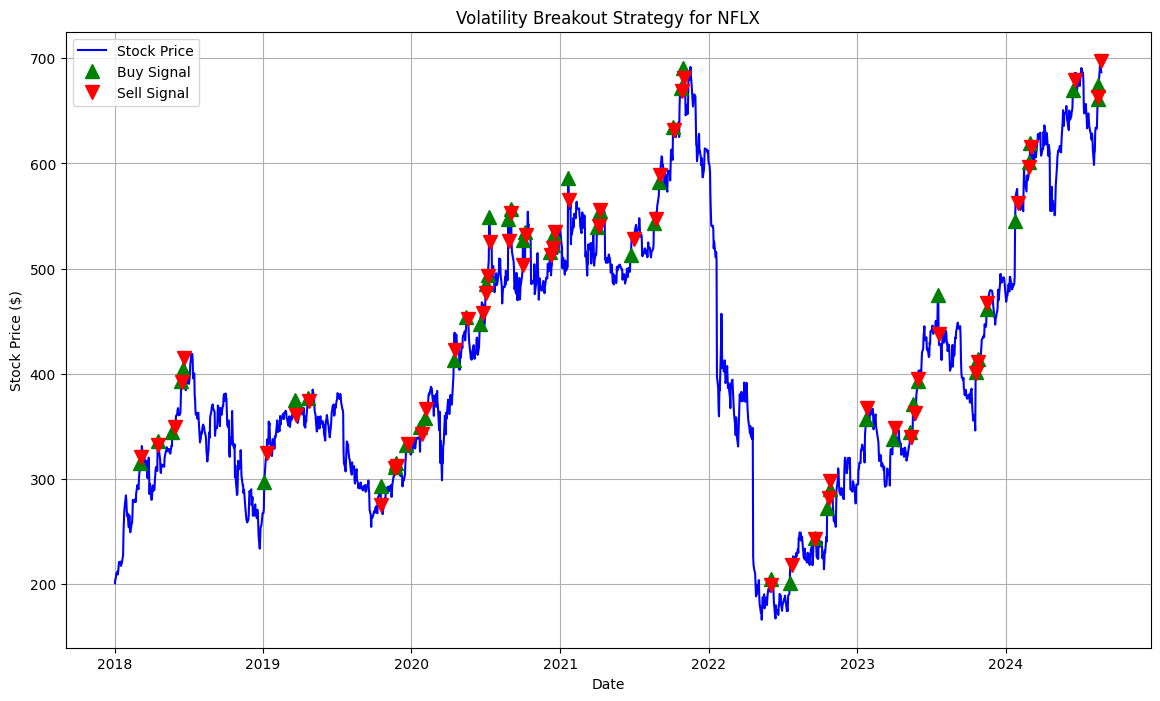

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:64: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data < data.max() * level

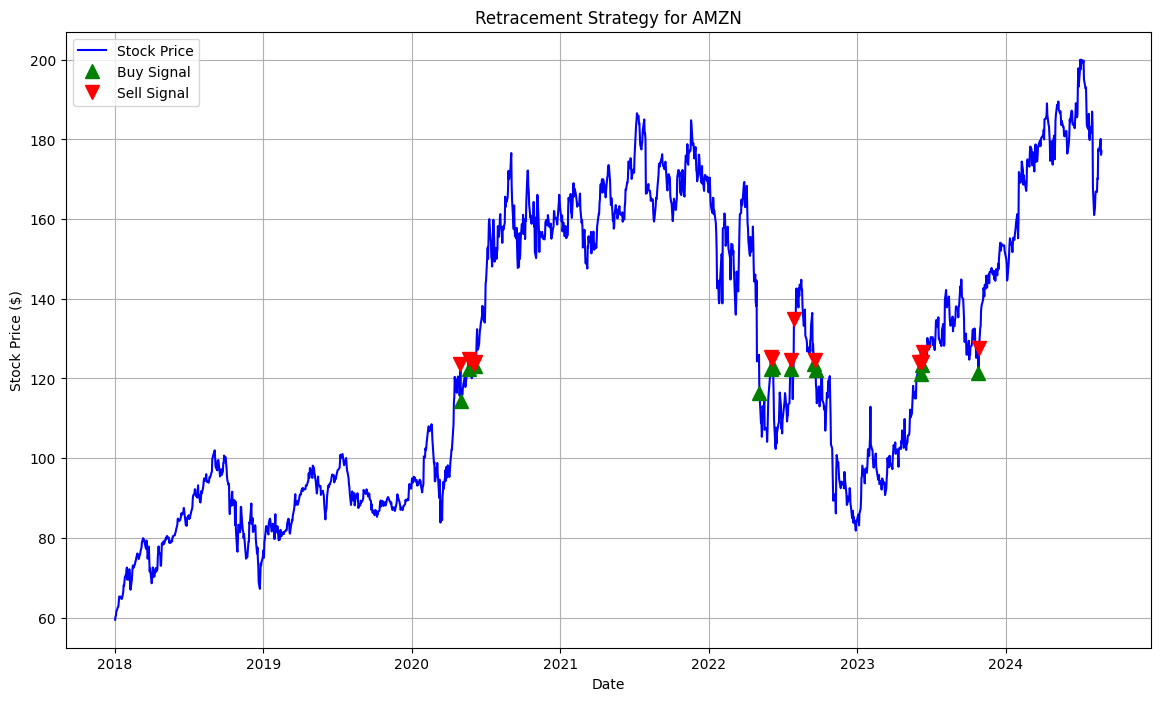

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:64: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data < data.max() * level

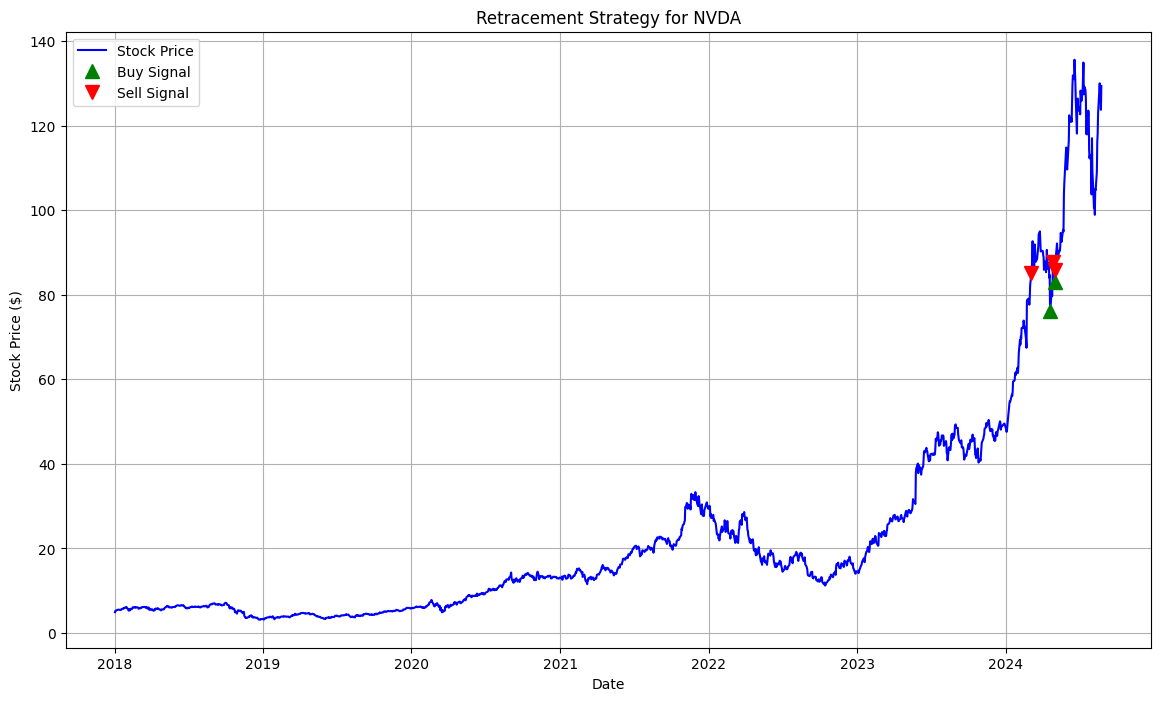

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:64: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data < data.max() * level

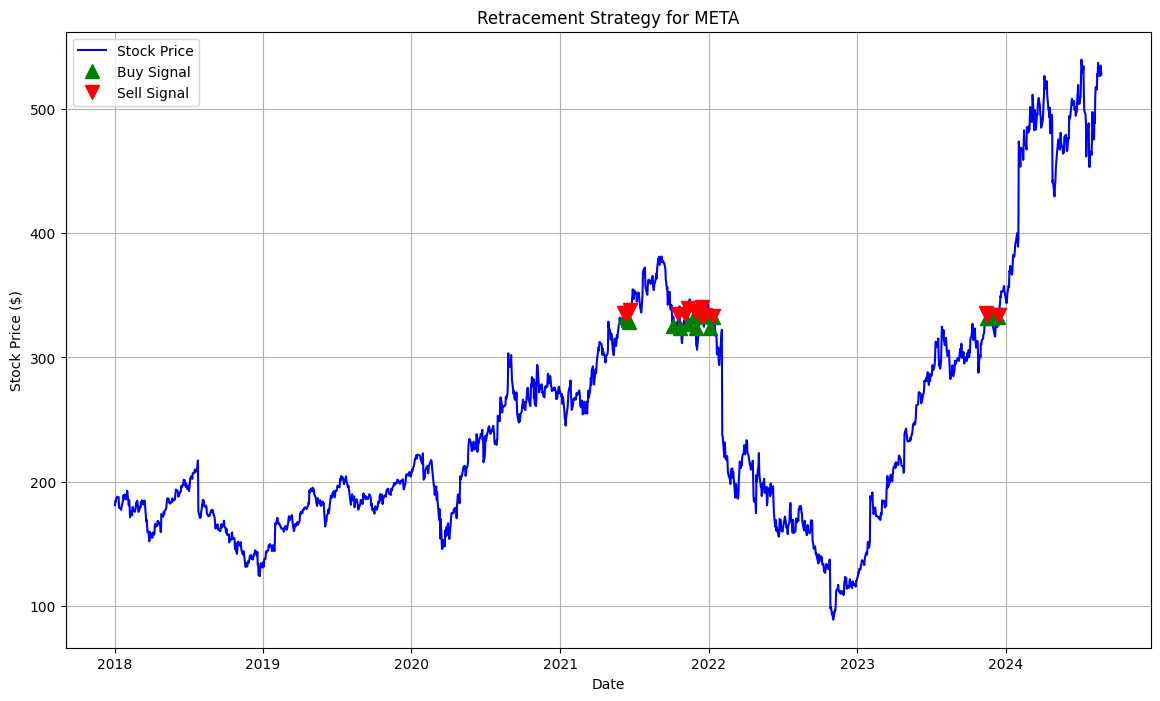

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:70: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data > span_a] = 1.0


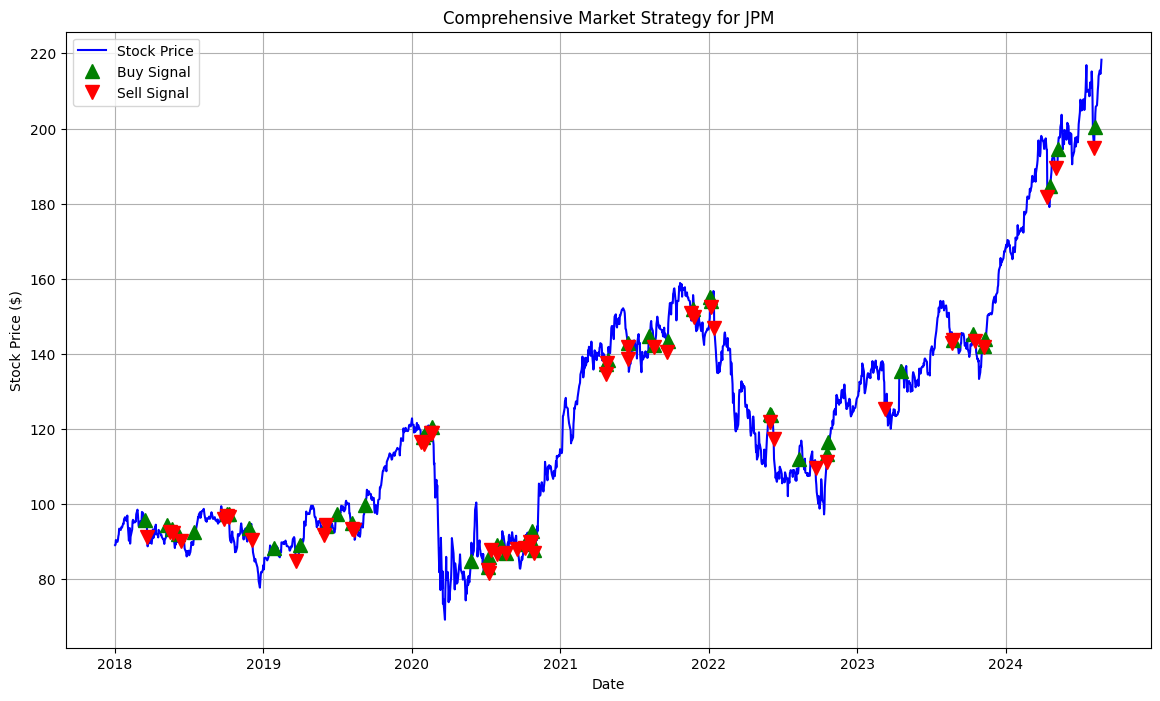

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:70: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data > span_a] = 1.0


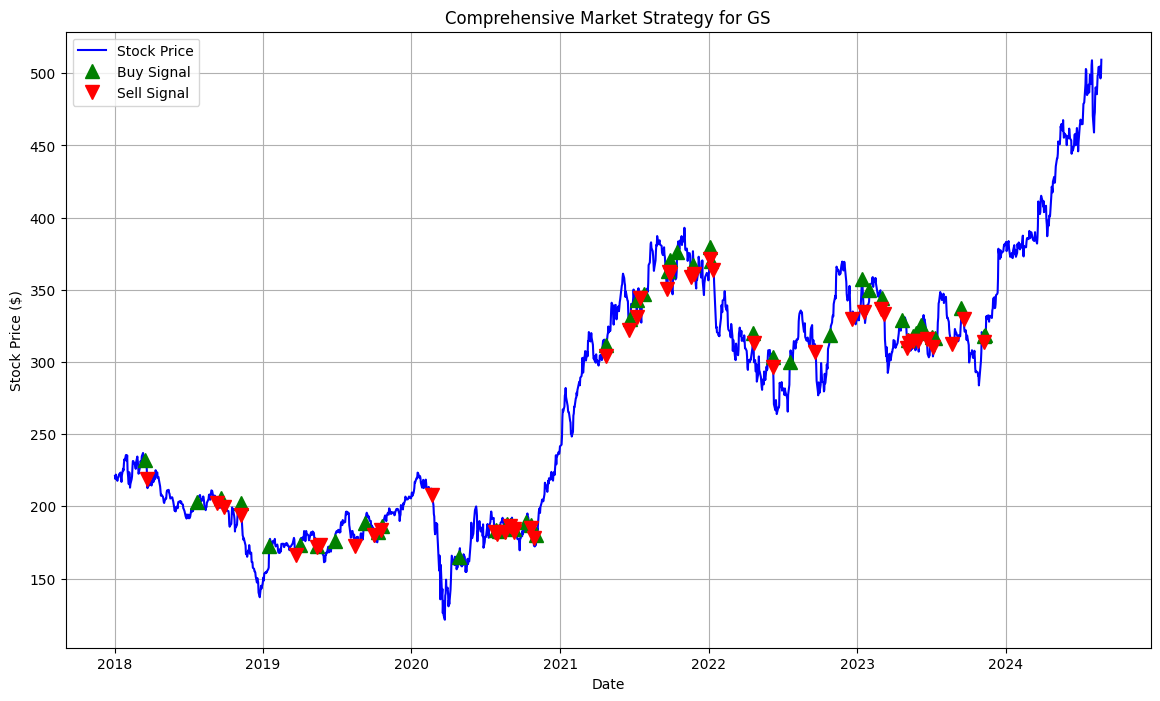

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:70: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][data > span_a] = 1.0


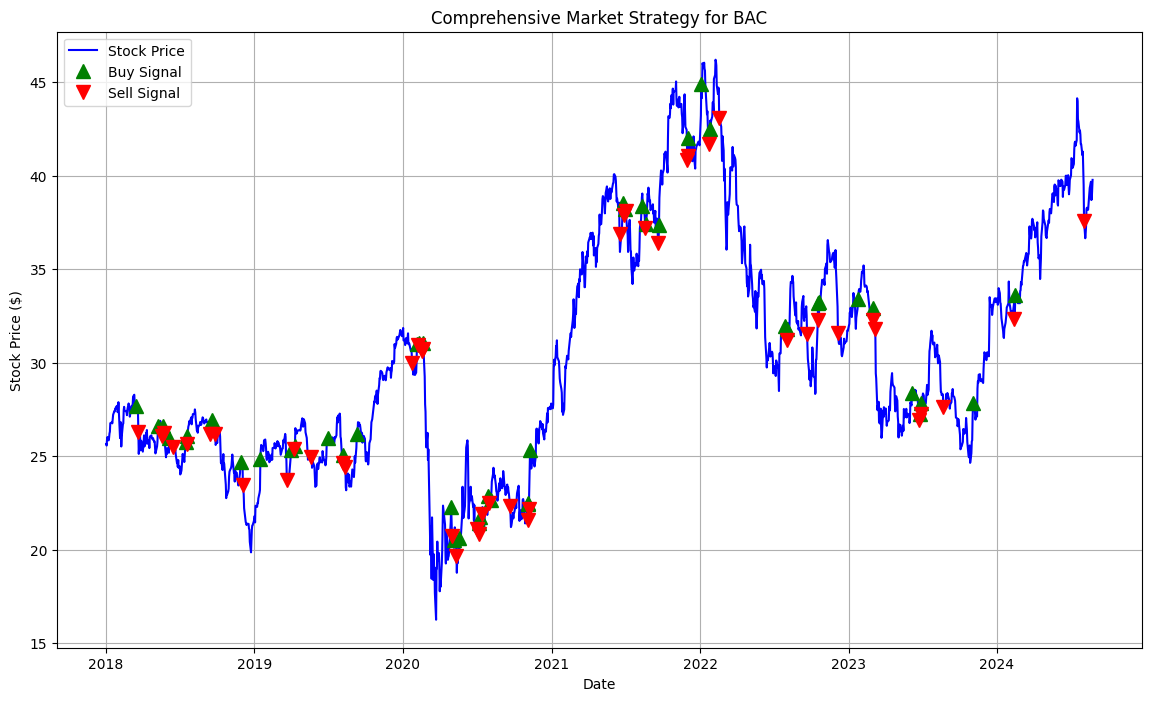

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:78: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][(data > vwap) & (macd > m

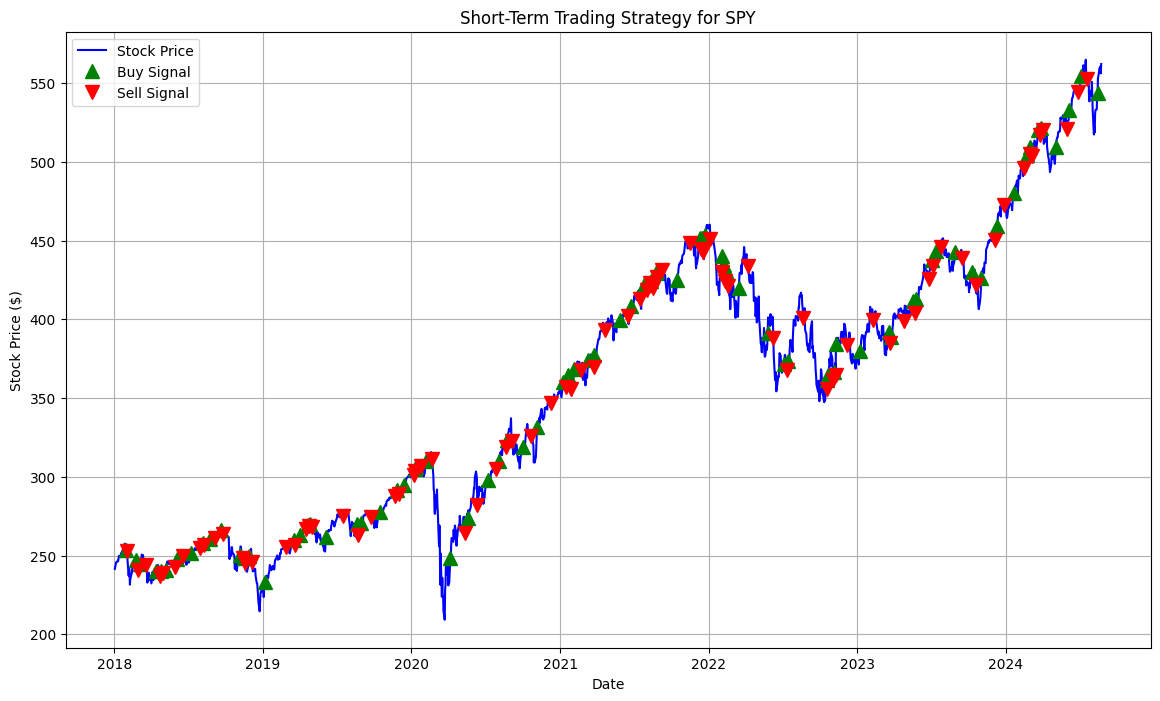

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:78: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][(data > vwap) & (macd > m

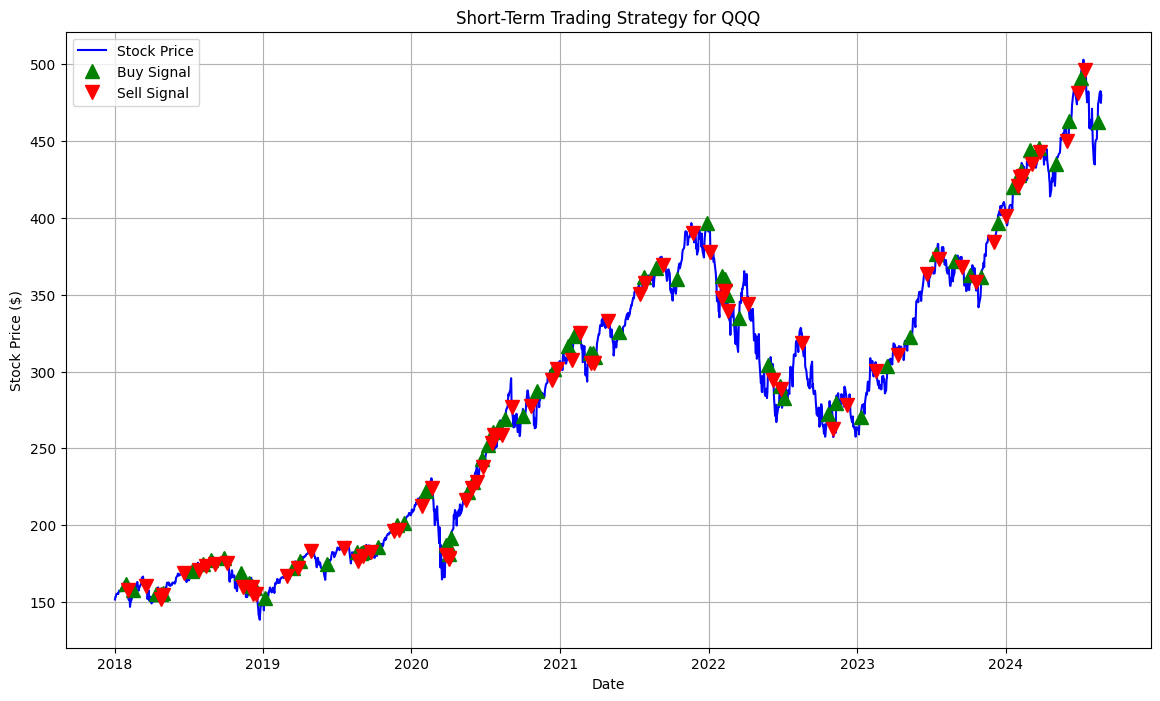

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/2188318559.py:78: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][(data > vwap) & (macd > m

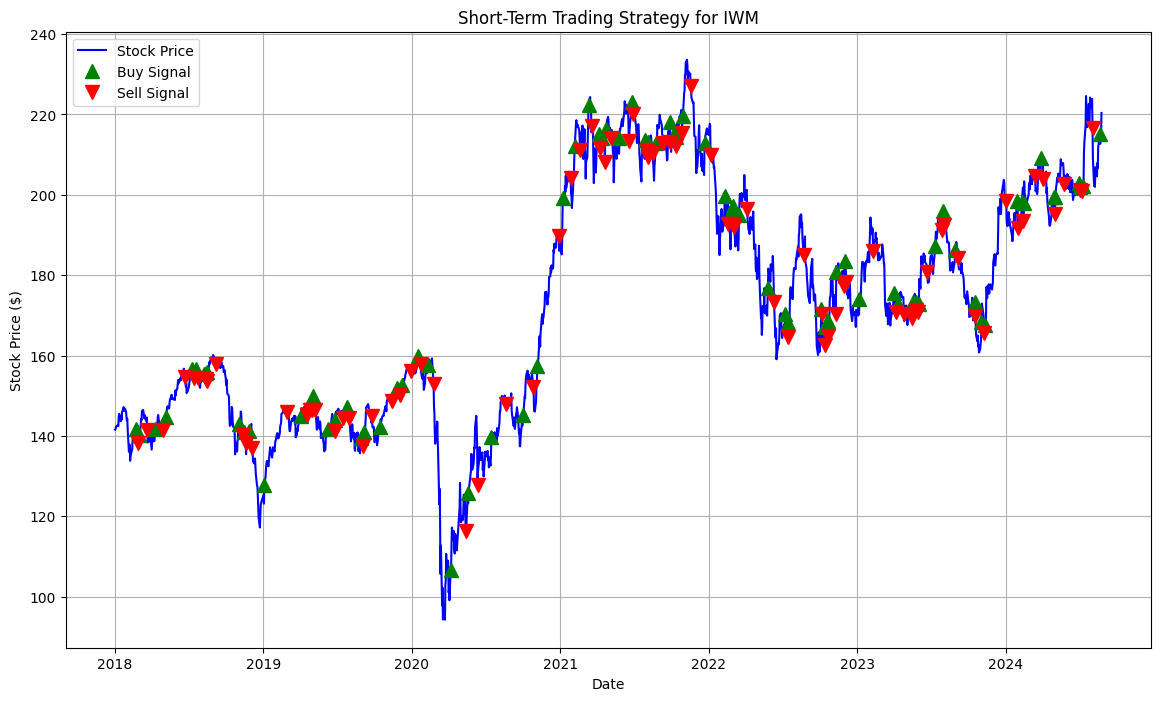

In [22]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

strategies = {
    "Trend Following": ["AAPL", "MSFT", "GOOGL"],
    "Volatility Breakout": ["TSLA", "AMD", "NFLX"],
    "Retracement": ["AMZN", "NVDA", "META"],
    "Comprehensive Market": ["JPM", "GS", "BAC"],
    "Short-Term Trading": ["SPY", "QQQ", "IWM"]
}

start_date = "2018-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

def moving_average(data, window):
    return data.rolling(window=window).mean()

def bollinger_bands(data, window=20):
    rolling_mean = moving_average(data, window)
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band, rolling_mean

def ichimoku_cloud(data):
    nine_period_high = data.rolling(window=9).max()
    nine_period_low = data.rolling(window=9).min()
    tenkan_sen = (nine_period_high + nine_period_low) / 2

    period26_high = data.rolling(window=26).max()
    period26_low = data.rolling(window=26).min()
    kijun_sen = (period26_high + period26_low) / 2

    span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
    span_b = ((data.rolling(window=52).max() + data.rolling(window=52).min()) / 2).shift(26)

    return span_a, span_b, tenkan_sen, kijun_sen

def simulate_strategy(strategy_name, stock):
    data = yf.download(stock, start=start_date, end=end_date)['Adj Close']
    signals = pd.DataFrame(index=data.index)
    
    if strategy_name == "Trend Following":
        short_ma = moving_average(data, 50)
        long_ma = moving_average(data, 200)
        signals['signal'] = 0.0
        signals['signal'][short_ma > long_ma] = 1.0
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Volatility Breakout":
        upper_band, lower_band, middle_band = bollinger_bands(data)
        signals['signal'] = 0.0
        signals['signal'][data > upper_band] = 1.0
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Retracement":
        fib_levels = [0.382, 0.5, 0.618]
        signals['signal'] = 0.0
        for level in fib_levels:
            signals['signal'][data < data.max() * level] = 1.0  
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Comprehensive Market":
        span_a, span_b, tenkan_sen, kijun_sen = ichimoku_cloud(data)
        signals['signal'] = 0.0
        signals['signal'][data > span_a] = 1.0
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Short-Term Trading":
        vwap = data.rolling(window=20).mean() 
        macd = data.ewm(span=12).mean() - data.ewm(span=26).mean()
        macd_signal = macd.ewm(span=9).mean()
        signals['signal'] = 0.0
        signals['signal'][(data > vwap) & (macd > macd_signal)] = 1.0
        signals['positions'] = signals['signal'].diff()

    initial_capital = 20000
    positions = signals['signal'].fillna(0) * (initial_capital / data[0])
    portfolio = positions.multiply(data, axis=0)
    portfolio['holdings'] = positions * data
    portfolio['cash'] = initial_capital - (positions.diff() * data).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    plt.figure(figsize=(14, 8))
    plt.plot(portfolio['total'], label='Portfolio Value', color='blue')
    plt.plot(signals.loc[signals.positions == 1.0].index,
             portfolio.total[signals.positions == 1.0],
             '^', markersize=10, color='green', label='Buy Signal')
    plt.plot(signals.loc[signals.positions == -1.0].index,
             portfolio.total[signals.positions == -1.0],
             'v', markersize=10, color='red', label='Sell Signal')
    plt.title(f'{strategy_name} Strategy for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return portfolio

portfolios = {}
for strategy, stocks in strategies.items():
    for stock in stocks:
        portfolios[f'{strategy}_{stock}'] = simulate_strategy(strategy, stock)


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

strategies = {
    "Trend Following": ["AAPL", "MSFT", "GOOGL"],
    "Volatility Breakout": ["TSLA", "AMD", "NFLX"],
    "Retracement": ["AMZN", "NVDA", "META"],
    "Comprehensive Market": ["JPM", "GS", "BAC"],
    "Short-Term Trading": ["SPY", "QQQ", "IWM"]
}

start_date = "2018-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

def moving_average(data, window):
    return data.rolling(window=window).mean()

def bollinger_bands(data, window=20):
    rolling_mean = moving_average(data, window)
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band, rolling_mean

def ichimoku_cloud(data):
    nine_period_high = data.rolling(window=9).max()
    nine_period_low = data.rolling(window=9).min()
    tenkan_sen = (nine_period_high + nine_period_low) / 2

    period26_high = data.rolling(window=26).max()
    period26_low = data.rolling(window=26).min()
    kijun_sen = (period26_high + period26_low) / 2

    span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
    span_b = ((data.rolling(window=52).max() + data.rolling(window=52).min()) / 2).shift(26)

    return span_a, span_b, tenkan_sen, kijun_sen

def simulate_strategy(strategy_name, stock):
    data = yf.download(stock, start=start_date, end=end_date)['Adj Close']
    signals = pd.DataFrame(index=data.index)
    
    if strategy_name == "Trend Following":
        short_ma = moving_average(data, 50)
        long_ma = moving_average(data, 200)
        signals['signal'] = 0.0
        signals['signal'][short_ma > long_ma] = 1.0
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Volatility Breakout":
        upper_band, lower_band, middle_band = bollinger_bands(data)
        signals['signal'] = 0.0
        signals['signal'][data > upper_band] = 1.0
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Retracement":
        fib_levels = [0.382, 0.5, 0.618]
        signals['signal'] = 0.0
        for level in fib_levels:
            signals['signal'][data < data.max() * level] = 1.0 
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Comprehensive Market":
        span_a, span_b, tenkan_sen, kijun_sen = ichimoku_cloud(data)
        signals['signal'] = 0.0
        signals['signal'][data > span_a] = 1.0
        signals['positions'] = signals['signal'].diff()
    
    elif strategy_name == "Short-Term Trading":
        vwap = data.rolling(window=20).mean() 
        macd = data.ewm(span=12).mean() - data.ewm(span=26).mean()
        macd_signal = macd.ewm(span=9).mean()
        signals['signal'] = 0.0
        signals['signal'][(data > vwap) & (macd > macd_signal)] = 1.0
        signals['positions'] = signals['signal'].diff()

    plt.figure(figsize=(14, 8))
    plt.plot(data, label='Stock Price', color='blue')
    plt.plot(signals.loc[signals.positions == 1.0].index,
             data[signals.positions == 1.0],
             '^', markersize=10, color='green', label='Buy Signal')
    plt.plot(signals.loc[signals.positions == -1.0].index,
             data[signals.positions == -1.0],
             'v', markersize=10, color='red', label='Sell Signal')
    plt.title(f'{strategy_name} Strategy for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return data

for strategy, stocks in strategies.items():
    for stock in stocks:
        simulate_strategy(strategy, stock)


[*********************100%%**********************]  15 of 15 completed


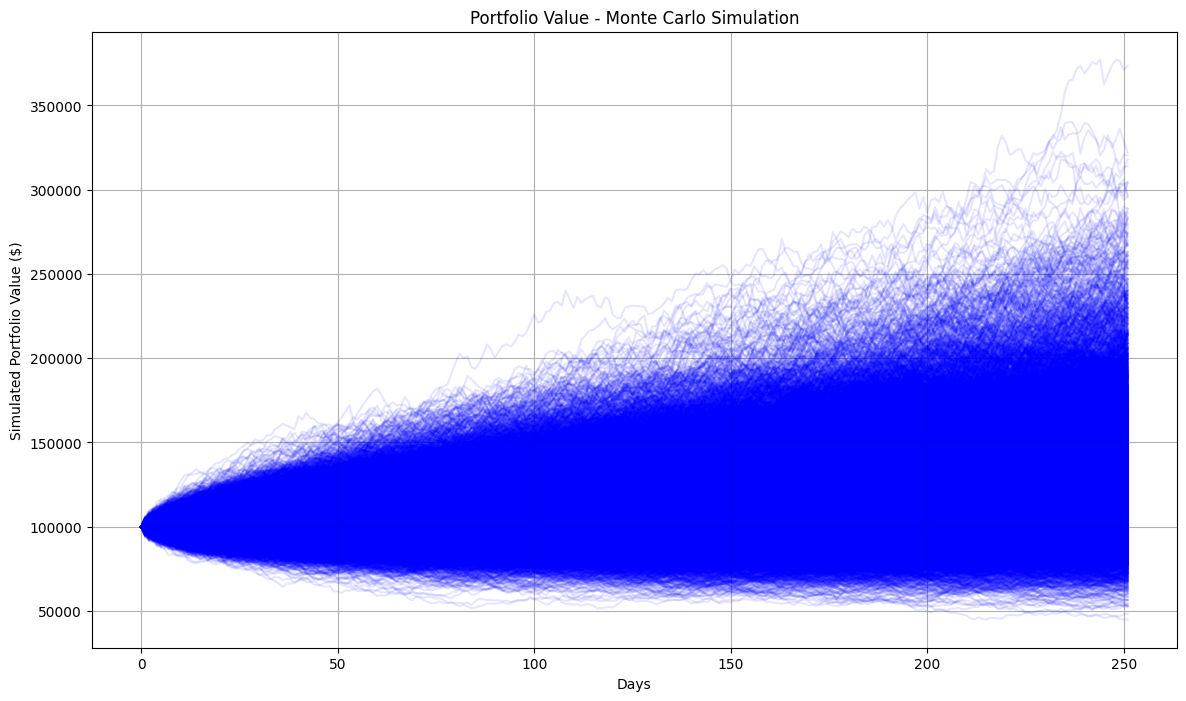

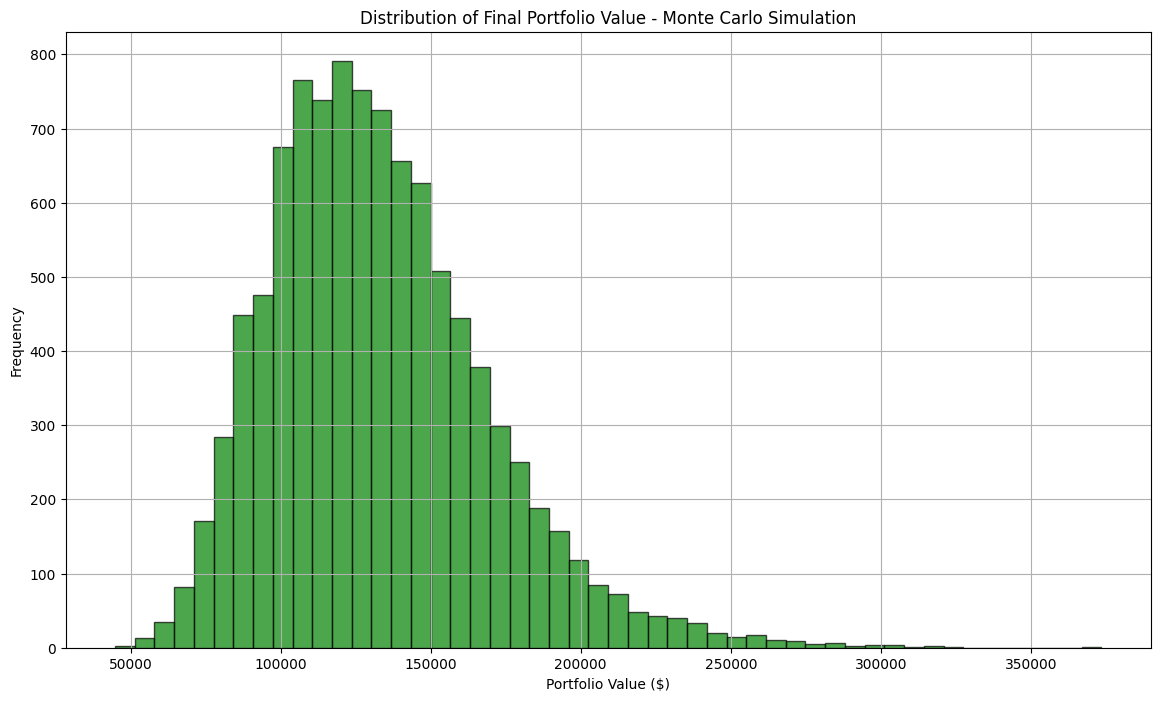

Expected Portfolio Value: $132,658.21
95% Confidence Interval: ($75,951.49, $216,276.68)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

num_simulations = 10000
time_horizon = 252 

def monte_carlo_simulation(aggregated_returns, initial_portfolio_value, num_simulations, time_horizon):
    mean_return = aggregated_returns.mean()
    volatility = aggregated_returns.std()

    simulations = np.zeros((time_horizon, num_simulations))
    simulations[0] = initial_portfolio_value

    for i in range(1, time_horizon):
        shock = np.random.normal(loc=mean_return, scale=volatility, size=num_simulations)
        simulations[i] = simulations[i-1] * (1 + shock)
    
    return simulations

all_stocks = [stock for stocks in strategies.values() for stock in stocks]
data = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']

daily_returns = data.pct_change().dropna()
portfolio_daily_returns = daily_returns.mean(axis=1)

initial_portfolio_value = 100000  
simulations = monte_carlo_simulation(portfolio_daily_returns, initial_portfolio_value, num_simulations, time_horizon)

plt.figure(figsize=(14, 8))
plt.plot(simulations, color='blue', alpha=0.1) 
plt.title('Portfolio Value - Monte Carlo Simulation')
plt.xlabel('Days')
plt.ylabel('Simulated Portfolio Value ($)')
plt.grid(True)
plt.show()

final_portfolio_values = simulations[-1]

plt.figure(figsize=(14, 8))
plt.hist(final_portfolio_values, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Portfolio Value - Monte Carlo Simulation')
plt.xlabel('Portfolio Value ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

expected_value = np.mean(final_portfolio_values)
ci_lower = np.percentile(final_portfolio_values, 2.5)
ci_upper = np.percentile(final_portfolio_values, 97.5)

print(f"Expected Portfolio Value: ${expected_value:,.2f}")
print(f"95% Confidence Interval: (${ci_lower:,.2f}, ${ci_upper:,.2f})")


In [41]:
#99841.53

import alpaca_trade_api as tradeapi
import yfinance as yf
import pandas as pd
import numpy as np
import time

api = tradeapi.REST('PKAADT32B4ZQWT88QB6K', 'Pa12WaqgsKtSnQUxfrNqSmOhDVG5guS1LVqtMlLK', base_url='https://paper-api.alpaca.markets')

strategies = {
    "Trend Following": ["AAPL", "MSFT", "GOOGL"],
    "Volatility Breakout": ["TSLA", "AMD", "NFLX"],
    "Retracement": ["AMZN", "NVDA", "META"],
    "Comprehensive Market": ["JPM", "GS", "BAC"],
    "Short-Term Trading": ["SPY", "QQQ", "IWM"]
}

check_intervals = {
    "Trend Following": 86400,       # Daily
    "Volatility Breakout": 3600,     # Hourly
    "Retracement": 86400,            # Daily
    "Comprehensive Market": 604800,  # Weekly
    "Short-Term Trading": 1800       # Every 30 minutes
}

allocation_per_strategy = 20000

def moving_average(data, window):
    return data['Adj Close'].rolling(window=window).mean()

def bollinger_bands(data, window=20):
    rolling_mean = moving_average(data, window)
    rolling_std = data['Adj Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band, rolling_mean

def ichimoku_cloud(data):
    nine_period_high = data['Adj Close'].rolling(window=9).max()
    nine_period_low = data['Adj Close'].rolling(window=9).min()
    tenkan_sen = (nine_period_high + nine_period_low) / 2

    period26_high = data['Adj Close'].rolling(window=26).max()
    period26_low = data['Adj Close'].rolling(window=26).min()
    kijun_sen = (period26_high + period26_low) / 2

    span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
    span_b = ((data['Adj Close'].rolling(window=52).max() + data['Adj Close'].rolling(window=52).min()) / 2).shift(26)

    return span_a, span_b, tenkan_sen, kijun_sen

def fibonacci_retracement_levels(data):
    max_price = data['Adj Close'].max()
    min_price = data['Adj Close'].min()
    diff = max_price - min_price
    levels = {
        '0.236': max_price - 0.236 * diff,
        '0.382': max_price - 0.382 * diff,
        '0.500': max_price - 0.500 * diff,
        '0.618': max_price - 0.618 * diff,
        '0.786': max_price - 0.786 * diff,
    }
    return levels

def vwap(data):
    """Calculate the VWAP (Volume Weighted Average Price)."""
    cum_vol_price = (data['Adj Close'] * data['Volume']).cumsum()
    cum_volume = data['Volume'].cumsum()
    return cum_vol_price / cum_volume

def calculate_signal_strength(strategy_name, stock):
    data = yf.download(stock, period='1y', interval='1d')

    if strategy_name == "Trend Following":
        short_ma = moving_average(data, 50)
        long_ma = moving_average(data, 200)
        signal_strength = short_ma.iloc[-1] - long_ma.iloc[-1] 

    elif strategy_name == "Volatility Breakout":
        upper_band, lower_band, middle_band = bollinger_bands(data)
        signal_strength = data['Adj Close'].iloc[-1] - upper_band.iloc[-1]  

    elif strategy_name == "Retracement":
        levels = fibonacci_retracement_levels(data)
        signal_strength = min(levels['0.618'] - data['Adj Close'].iloc[-1], data['Adj Close'].iloc[-1] - levels['0.382']) 

    elif strategy_name == "Comprehensive Market":
        span_a, span_b, tenkan_sen, kijun_sen = ichimoku_cloud(data)
        signal_strength = (data['Adj Close'].iloc[-1] - span_a.iloc[-1]) + (tenkan_sen.iloc[-1] - kijun_sen.iloc[-1])  

    elif strategy_name == "Short-Term Trading":
        vw = vwap(data)
        macd = data['Adj Close'].ewm(span=12).mean() - data['Adj Close'].ewm(span=26).mean()
        macd_signal = macd.ewm(span=9).mean()
        signal_strength = (data['Adj Close'].iloc[-1] - vw.iloc[-1]) + (macd.iloc[-1] - macd_signal.iloc[-1]) 

    signal_strength = max(signal_strength, 0)  
    return signal_strength

def calculate_quantity_to_trade(stock_price, allocated_cash, signal_strength):
    normalized_strength = min(signal_strength, 1)  

    cash_to_use = allocated_cash * normalized_strength

    qty_to_buy = int(cash_to_use / stock_price)

    return qty_to_buy

def execute_trade(stock, side, qty):
    try:
        print(f"Attempting to {side} {qty} shares of {stock}")
        api.submit_order(
            symbol=stock,
            qty=qty,
            side=side,
            type='market',
            time_in_force='gtc'
        )
        print(f"Order executed: {side} {qty} shares of {stock}")
    except Exception as e:
        print(f"Error executing trade for {stock}: {e}")

def main():
    last_check_times = {strategy: 0 for strategy in strategies}

    while True:
        current_time = time.time()

        for strategy, stocks in strategies.items():
            if current_time - last_check_times[strategy] >= check_intervals[strategy]:
                allocated_cash = allocation_per_strategy / len(stocks)
                
                signals = []
                for stock in stocks:
                    signal_strength = calculate_signal_strength(strategy, stock)
                    signals.append((stock, signal_strength))
                
                signals.sort(key=lambda x: x[1], reverse=True)
                print(f"Sorted stocks by signal strength for {strategy} strategy: {signals}")
                
                for stock, strength in signals:
                    print(f"Checking signal for {stock} under {strategy} strategy with strength {strength}.")
                    position = None
                    try:
                        position = api.get_position(stock)
                        print(f"Existing position detected: {position.qty} shares of {stock}")
                    except:
                        print(f"No existing position detected for {stock}.")

                    if strength > 0.75:  
                        stock_price = yf.download(stock, period='1d')['Adj Close'].iloc[-1]
                        qty_to_buy = calculate_quantity_to_trade(stock_price, allocated_cash, strength)
                        if qty_to_buy > 0:
                            execute_trade(stock, 'buy', qty_to_buy)
                    elif strength > 0.25 and strength <= 0.75: 
                        print(f"Holding position for {stock}.")
                    elif strength <= 0.25 and position: 
                        qty_to_sell = int(position.qty) 
                        if qty_to_sell > 0:
                            execute_trade(stock, 'sell', qty_to_sell)
                        else:
                            print(f"No shares to sell for {stock}.")

                last_check_times[strategy] = current_time

        time.sleep(60)

if __name__ == "__main__":
    main()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Sorted stocks by signal strength for Trend Following strategy: [('AAPL', 27.4049308013916), ('MSFT', 25.08391906738285), ('GOOGL', 18.83148971557617)]
Checking signal for AAPL under Trend Following strategy with strength 27.4049308013916.


[*********************100%%**********************]  1 of 1 completed

No existing position detected for AAPL.
Attempting to buy 29 shares of AAPL



[*********************100%%**********************]  1 of 1 completed

Order executed: buy 29 shares of AAPL
Checking signal for MSFT under Trend Following strategy with strength 25.08391906738285.
No existing position detected for MSFT.
Attempting to buy 16 shares of MSFT



[*********************100%%**********************]  1 of 1 completed

Order executed: buy 16 shares of MSFT
Checking signal for GOOGL under Trend Following strategy with strength 18.83148971557617.
No existing position detected for GOOGL.
Attempting to buy 40 shares of GOOGL



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Order executed: buy 40 shares of GOOGL



[*********************100%%**********************]  1 of 1 completed


Sorted stocks by signal strength for Volatility Breakout strategy: [('TSLA', 0), ('AMD', 0), ('NFLX', 0)]
Checking signal for TSLA under Volatility Breakout strategy with strength 0.
No existing position detected for TSLA.
Checking signal for AMD under Volatility Breakout strategy with strength 0.
No existing position detected for AMD.
Checking signal for NFLX under Volatility Breakout strategy with strength 0.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

No existing position detected for NFLX.



[*********************100%%**********************]  1 of 1 completed


Sorted stocks by signal strength for Retracement strategy: [('AMZN', 0), ('NVDA', 0), ('META', 0)]
Checking signal for AMZN under Retracement strategy with strength 0.
No existing position detected for AMZN.
Checking signal for NVDA under Retracement strategy with strength 0.
No existing position detected for NVDA.
Checking signal for META under Retracement strategy with strength 0.


[*********************100%%**********************]  1 of 1 completed

No existing position detected for META.



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Sorted stocks by signal strength for Comprehensive Market strategy: [('GS', 44.732513427734375), ('JPM', 19.131366729736328), ('BAC', 0)]
Checking signal for GS under Comprehensive Market strategy with strength 44.732513427734375.
No existing position detected for GS.


[*********************100%%**********************]  1 of 1 completed


Attempting to buy 13 shares of GS
Order executed: buy 13 shares of GS
Checking signal for JPM under Comprehensive Market strategy with strength 19.131366729736328.


[*********************100%%**********************]  1 of 1 completed

No existing position detected for JPM.
Attempting to buy 30 shares of JPM


Order executed: buy 30 shares of JPM
Checking signal for BAC under Comprehensive Market strategy with strength 0.
No existing position detected for BAC.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Sorted stocks by signal strength for Short-Term Trading strategy: [('SPY', 80.09153834091332), ('QQQ', 62.28417787017637), ('IWM', 27.690734653853553)]
Checking signal for SPY under Short-Term Trading strategy with strength 80.09153834091332.
No existing position detected for SPY.


[*********************100%%**********************]  1 of 1 completed


Attempting to buy 11 shares of SPY
Order executed: buy 11 shares of SPY
Checking signal for QQQ under Short-Term Trading strategy with strength 62.28417787017637.
No existing position detected for QQQ.


[*********************100%%**********************]  1 of 1 completed


Attempting to buy 14 shares of QQQ
Order executed: buy 14 shares of QQQ
Checking signal for IWM under Short-Term Trading strategy with strength 27.690734653853553.


[*********************100%%**********************]  1 of 1 completed

No existing position detected for IWM.
Attempting to buy 30 shares of IWM


Order executed: buy 30 shares of IWM


KeyboardInterrupt: 